In [2]:
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import glob
import numpy as np
import os, glob
import csv
import operator

def prunDataFrame(dataframe):
    dataframe = dataframe.drop('geo', 1)
    dataframe = dataframe.drop('mx', 1)
    dataframe = dataframe.drop('mn', 1)
   # dataframe = dataframe.drop('wc', 1)


    dataframe = dataframe[['latency','start_ts','wc']].apply(pd.to_numeric,errors='coerce')
    dataframe = dataframe.sort_values(by='start_ts', ascending=[True])

   # dataframe = dataframe.drop('window', 1)
    return dataframe

def buildDataFrame(filePath):
    df_temp = pd.read_csv(filePath,names=['geo','latency','mx','mn','wc','start_ts'])
    df_temp = prunDataFrame(df_temp)
    return df_temp


def pruneForDenseWindows(dataframe,percentage):
    pd.to_numeric(dataframe.wc)
    topWindows = dataframe.wc.quantile(percentage)
    #print(topWindows)
    dataframe = dataframe[dataframe.wc > topWindows  ]
    return dataframe


def pandasDraw(listOfFilePaths,_figsize,_range,_quantile=None):
    for fileGroup in listOfFilePaths:
        df_list = []
        for file in fileGroup:
            column_name = file.rsplit('.', 1)[0]
            temp_df = buildDataFrame(file)
            if not (_quantile is None):
                temp_df = pruneForDenseWindows(temp_df,_quantile)
            temp_df_with_cols = pd.DataFrame({column_name:temp_df.latency},
                    columns=[column_name])
            df_list.append(temp_df_with_cols)
        df_final = pd.concat(df_list)
        ax_df_final = df_final.hist(figsize=_figsize,bins=100,range=_range)
    plt.show()
    


def dataGeneratorStats(path,_figsize):
    d = {}
    fileCount = 0
    for filePath in glob.glob(path + '*'):
        fileCount = fileCount + 1
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) , 1
            k = int(k)
            if k in d:
                d[k]  = tuple(map(operator.add, d[k], v))
            else:
                d[k] = v
    finalD = {}
    for k, v in d.items():
        if v[1] == fileCount:
            finalD[k] = v[0]
    df = pd.DataFrame(list(finalD.items()),columns=['ts', 'count'])
    df = df.sort_values(by='ts', ascending=[True])
    df.plot.bar(y='count', x = 'ts',figsize=_figsize,)
    plt.show()

def dataGeneratorStatsSeparate(path,_figsize,_xlabel,_ylabel,_xticks):
    df_list = []
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] , 'count': [int(i[1]) for i in d.items()]},columns=['ts', 'count'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df_list.append(df)
        ax=df.plot(y='count', x = 'ts',figsize=_figsize, xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks) ,marker='x')
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)

    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    plt.show()

def dataGeneratorStatsSeparateOneAxis(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] },columns=['ts'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df['count'] = list(range(1, len(df) + 1))


        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

def dataGeneratorStatsSeparateOneAxis2(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        df = pd.read_csv(filePath,names=['ts','count'])
        df['count'] = df['count']/1000000;
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl

        

        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

def latencyTimeSeries(path,_figsize,_xticks):
    temp_df  = buildDataFrame(path)
    df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts, 'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])
    # df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))



    # plt.show()

    df = df.sort_values(by='start_ts', ascending=[True])
    minEl = df.start_ts.iloc[0]
    df['start_ts'] = df['start_ts'] - minEl
    df['start_ts'] = df['start_ts'] /1000
    df.plot.line(y='latency', x = 'start_ts',figsize=_figsize,xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), _xticks))
    plt.show()

    print('Latency quantile is:')
    df.latency.plot.box()
    plt.show()
    print('average latency is:')
    print(df.latency.mean())

    print(' window size quantile is:')
    df.wc.plot.box()
    plt.show()
    print('average window size is:')
    print(df.wc.mean())






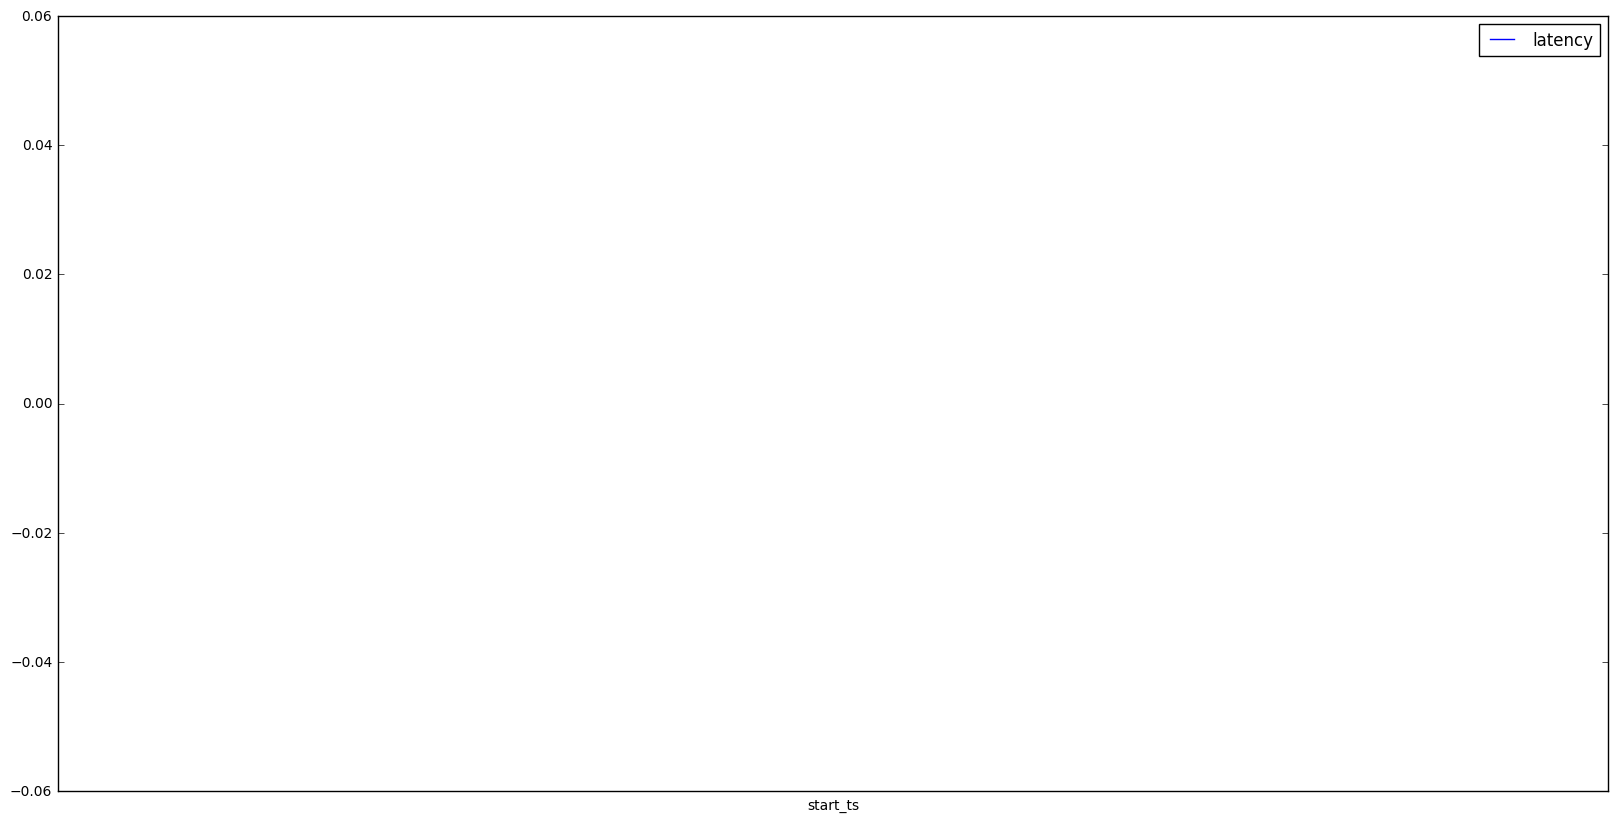

Latency quantile is:


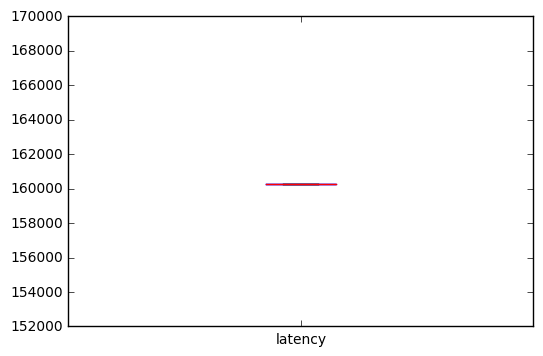

average latency is:
160280.0
 window size quantile is:


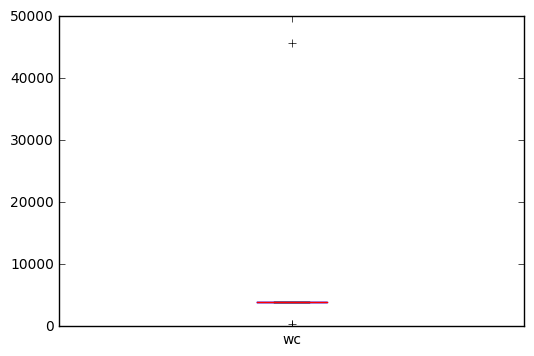

average window size is:
5755.10526316


In [4]:
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/trident/1x/results/trident_temp.csv',(20,10),25)

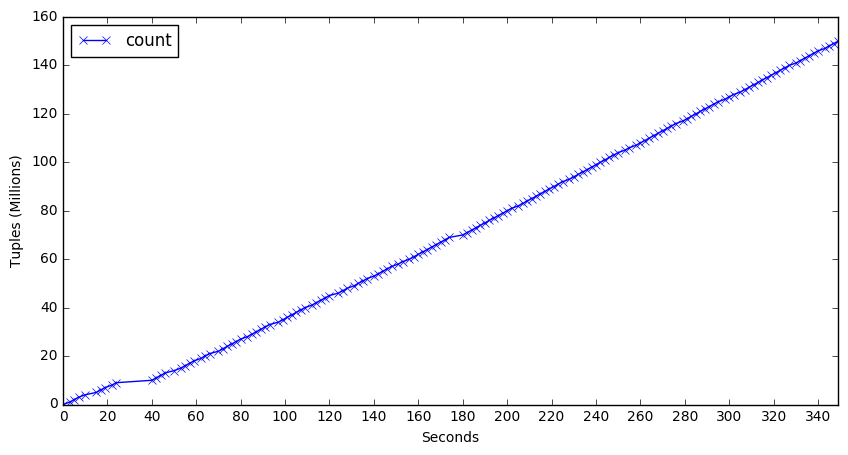

In [52]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/flink/1x/stats/consumer',(10,5),'Seconds','Tuples (Millions)',20)



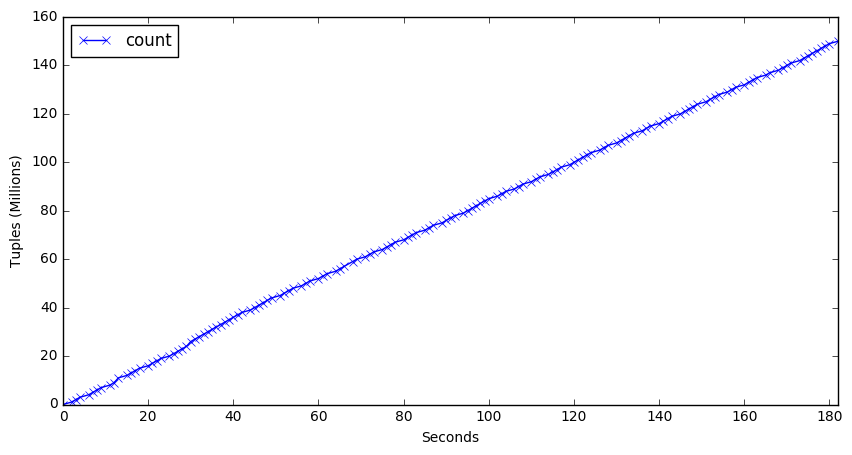

In [49]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/flink/1x/stats/producer',(10,5),'Seconds','Tuples (Millions)',20)




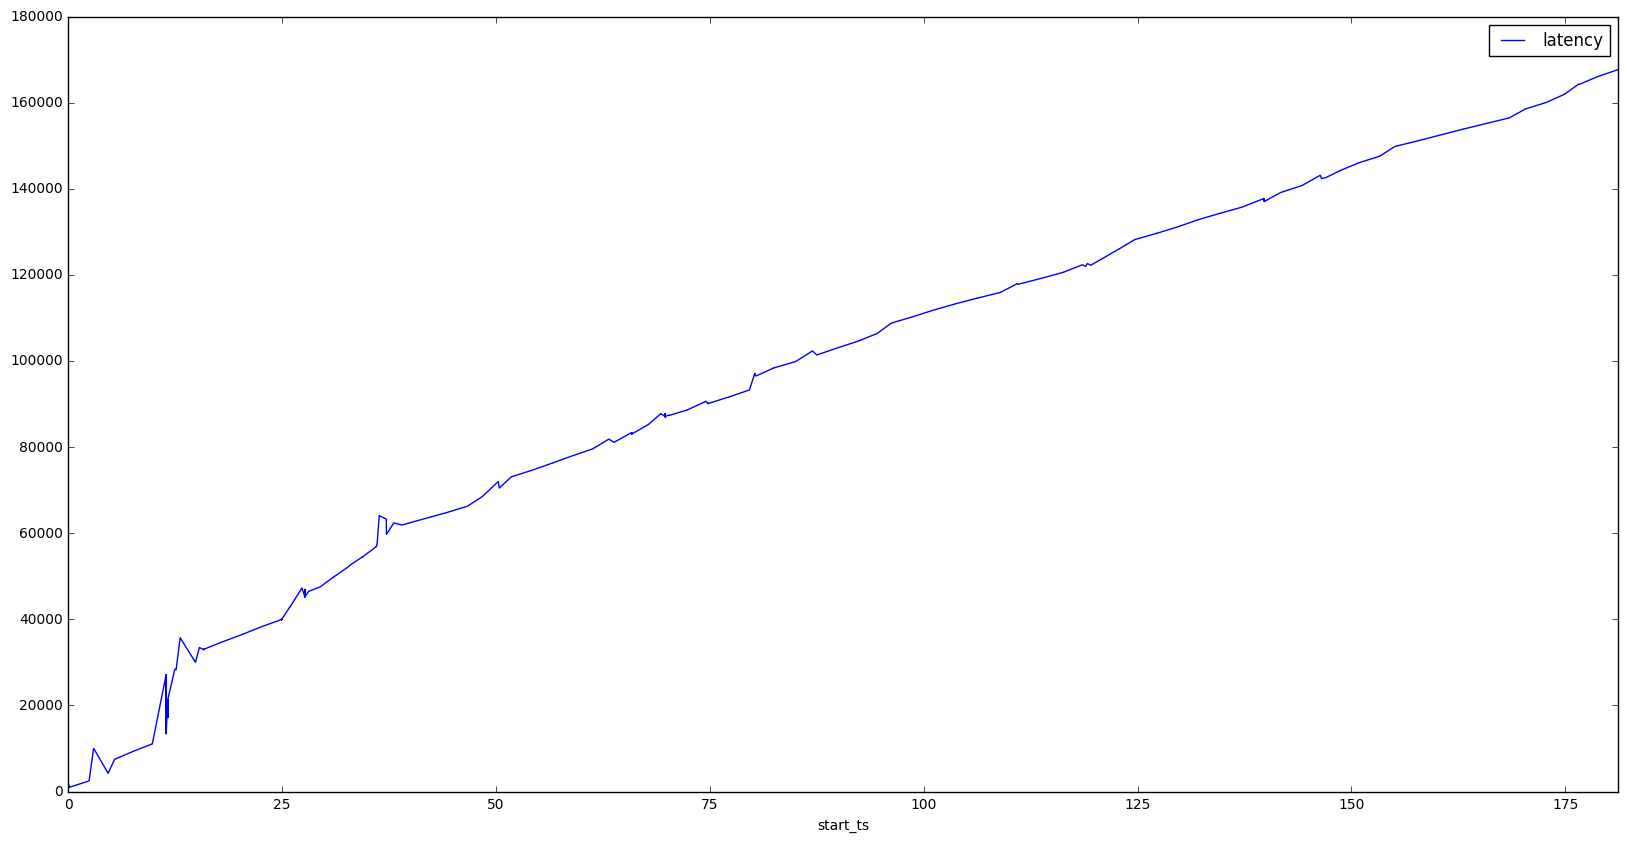

Latency quantile is:


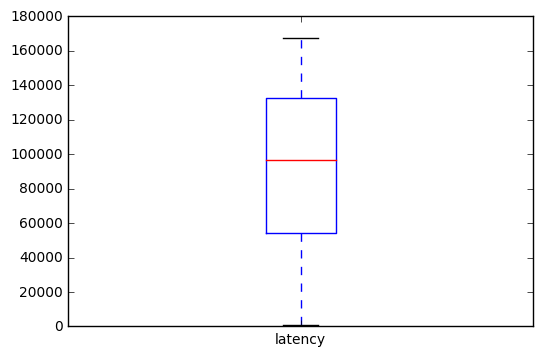

average latency is:
92166.9595202
 window size quantile is:


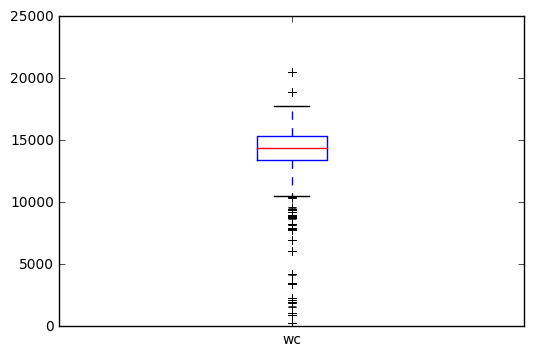

average window size is:
13535.8343555


In [50]:
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/flink/1x/results/flink_temp.csv',(20,10),25)

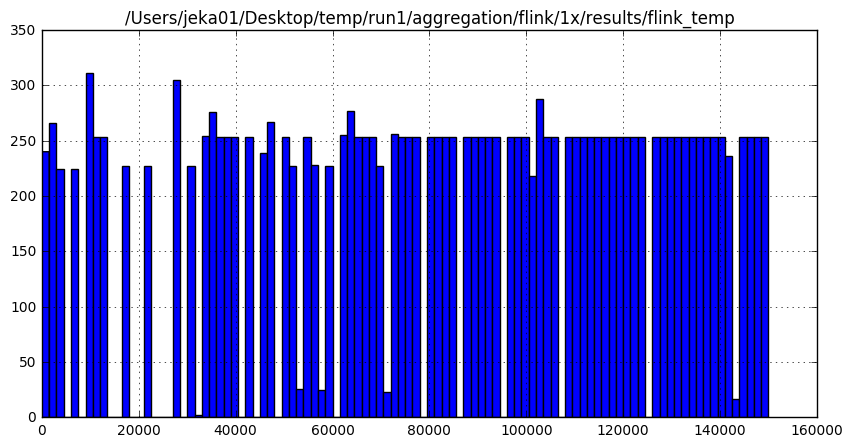

In [51]:
range = [0,150000]

pandasDraw([['/Users/jeka01/Desktop/temp/run1/aggregation/flink/1x/results/flink_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

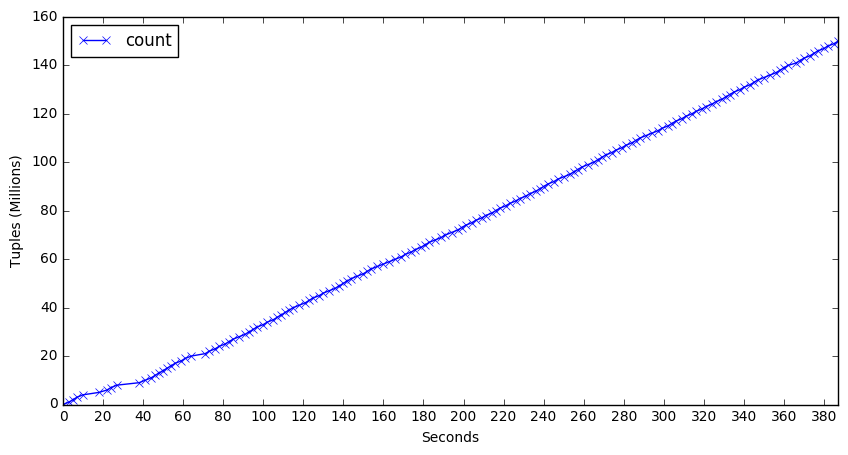

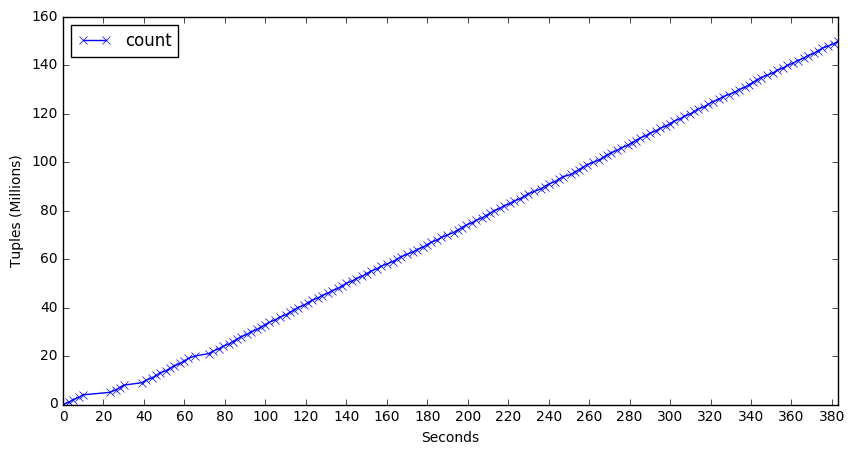

In [43]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/flink/2x/stats/consumer',(10,5),'Seconds','Tuples (Millions)',20)



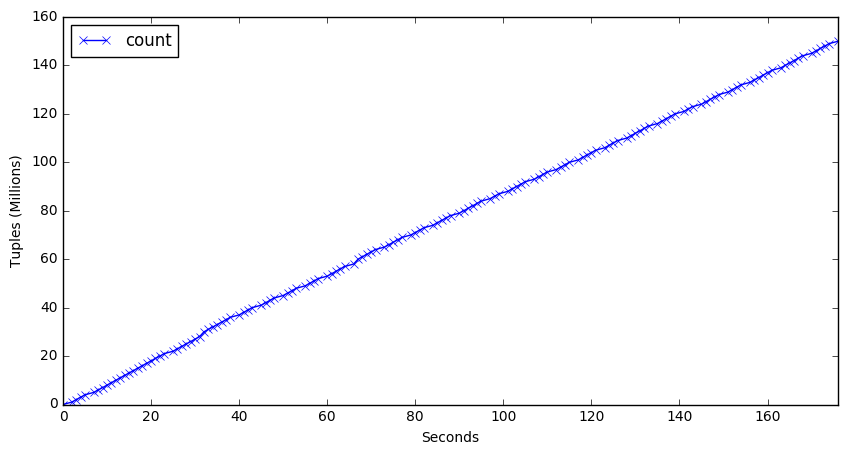

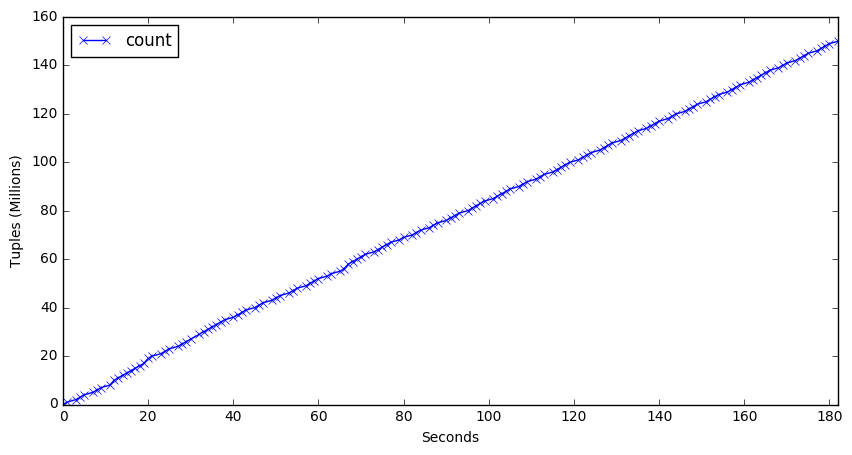

In [44]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/flink/2x/stats/producer',(10,5),'Seconds','Tuples (Millions)',20)



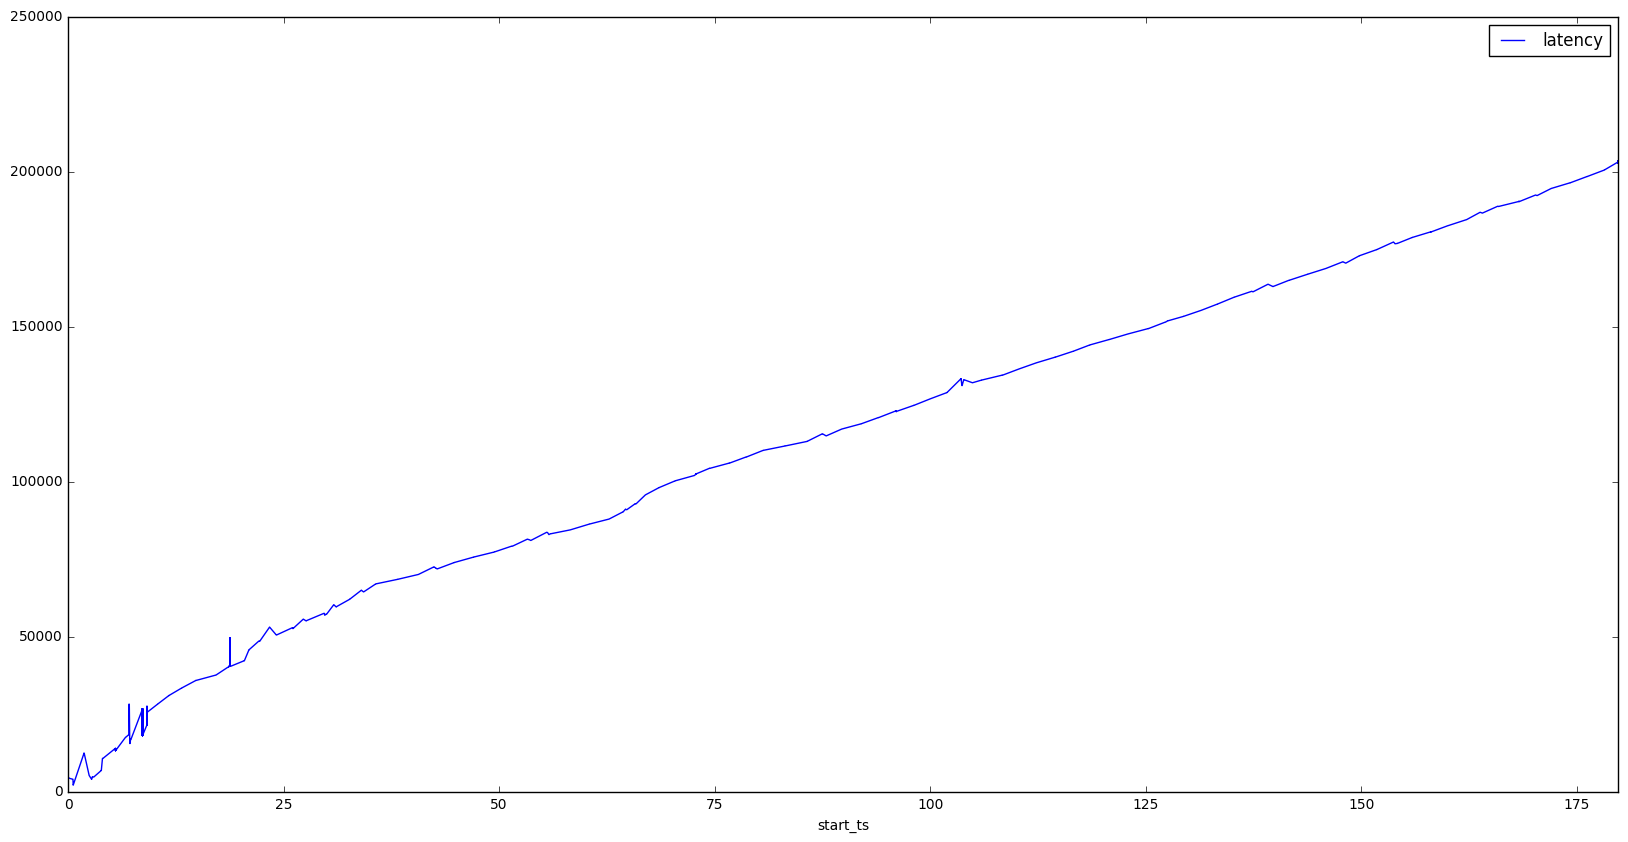

Latency quantile is:


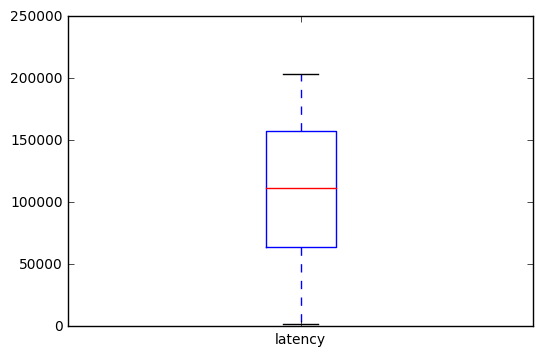

average latency is:
108347.935326
 window size quantile is:


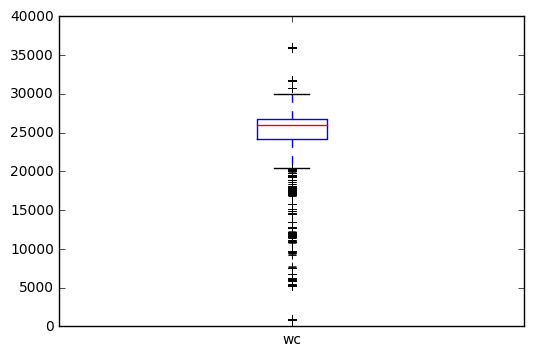

average window size is:
24490.663108


In [45]:
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/flink/2x/results/flink_temp.csv',(20,10),25)

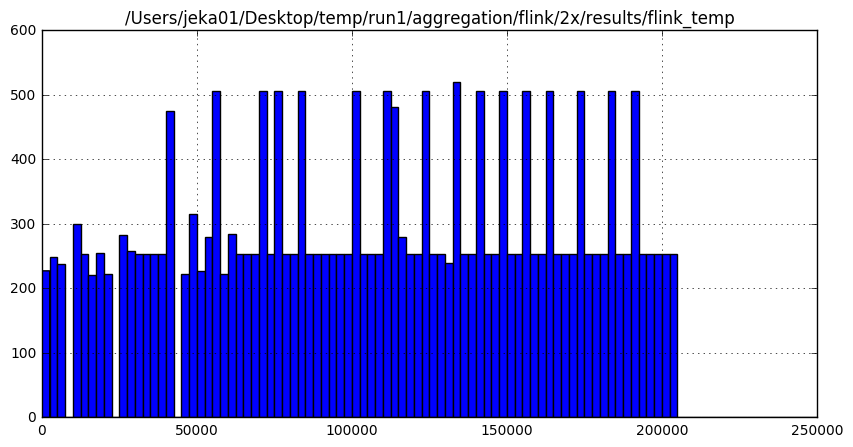

In [46]:
range = [0,250000]

pandasDraw([['/Users/jeka01/Desktop/temp/run1/aggregation/flink/2x/results/flink_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

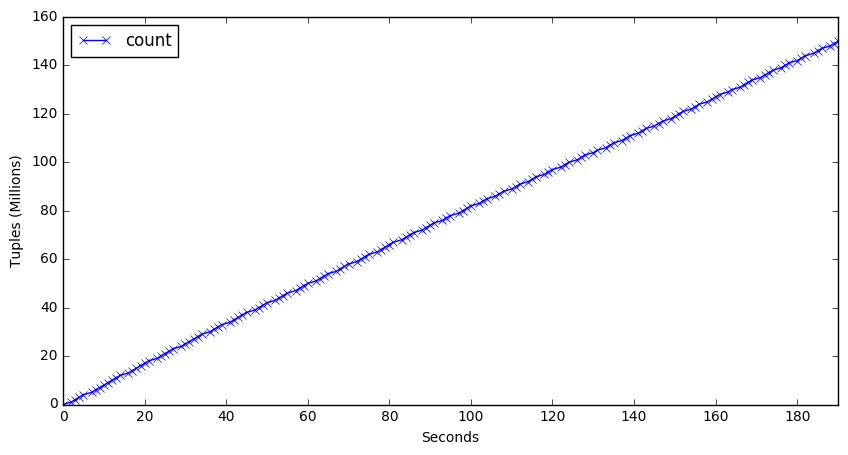

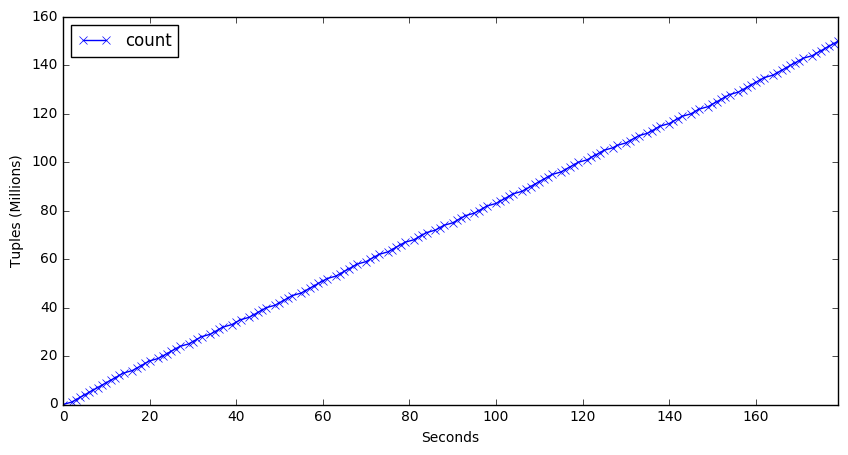

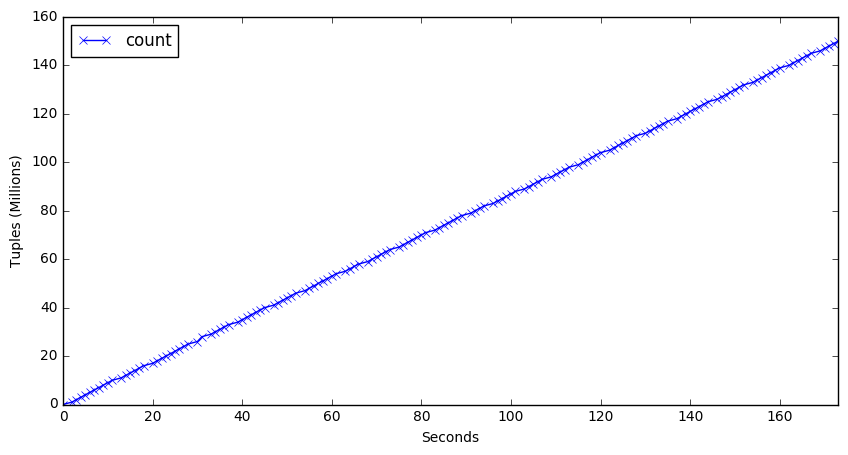

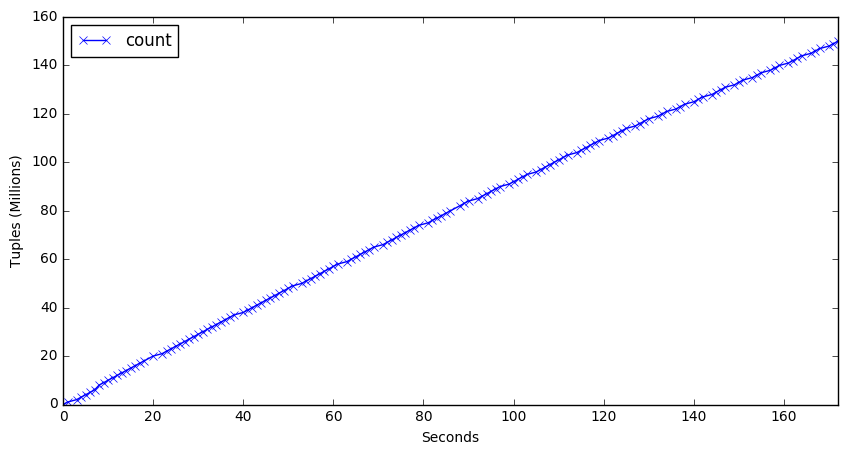

In [53]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/flink/4x/stats/producer',(10,5),'Seconds','Tuples (Millions)',20)



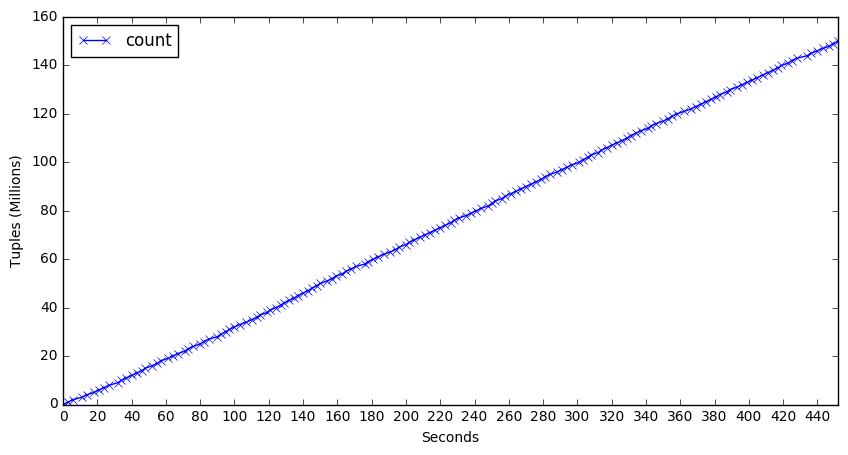

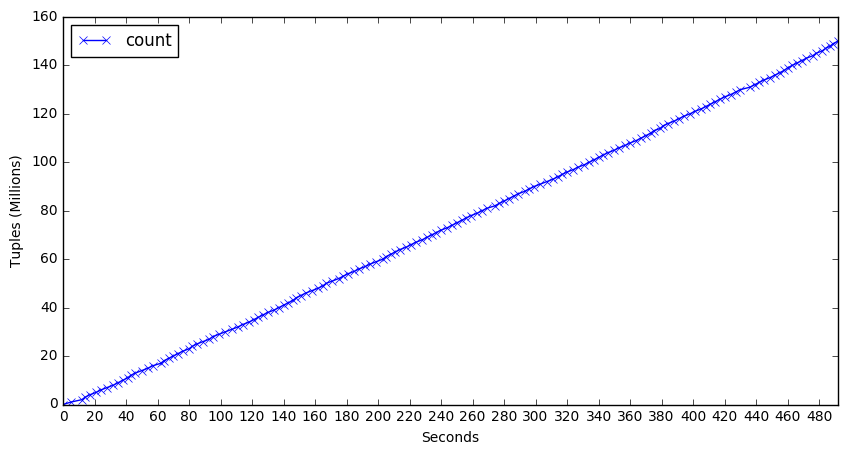

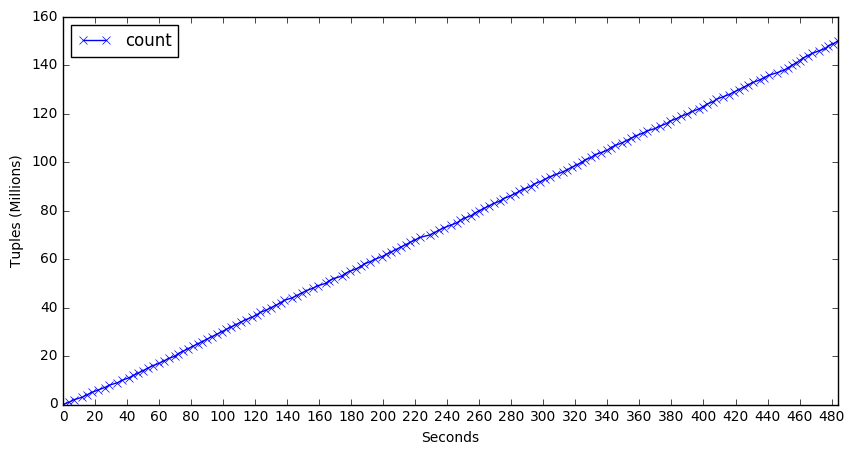

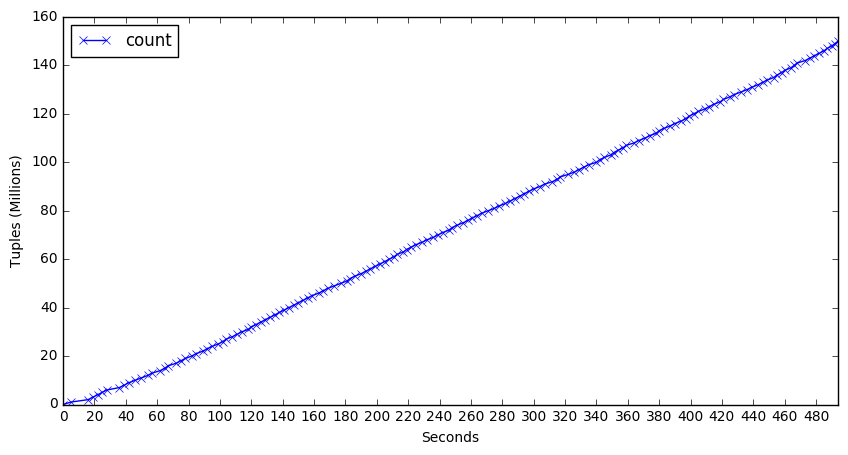

In [54]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/flink/4x/stats/consumer',(10,5),'Seconds','Tuples (Millions)',20)



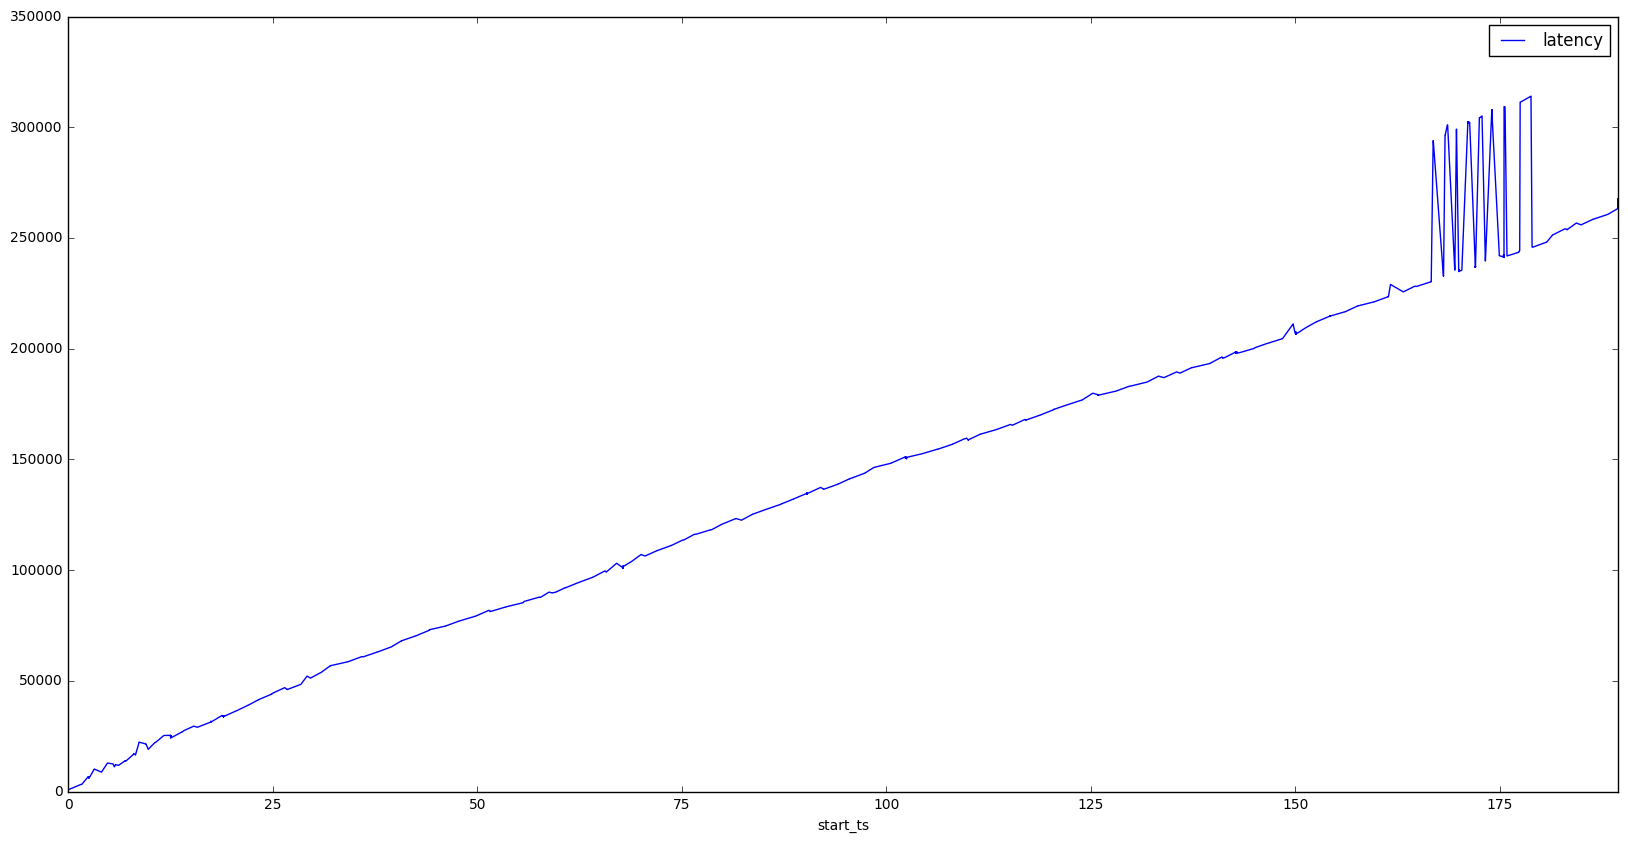

Latency quantile is:


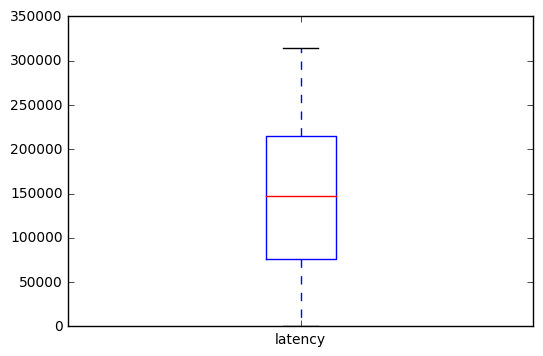

average latency is:
147478.952888
 window size quantile is:


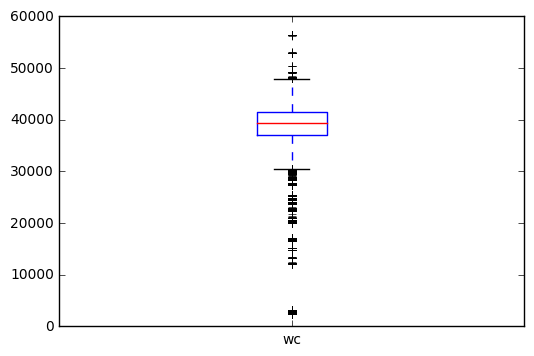

average window size is:
38095.698521


In [55]:
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/flink/4x/results/flink_temp.csv',(20,10),25)

ERROR TaskSchedulerImpl: Lost executor 7 on 130.149.21.20: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages
Crashed


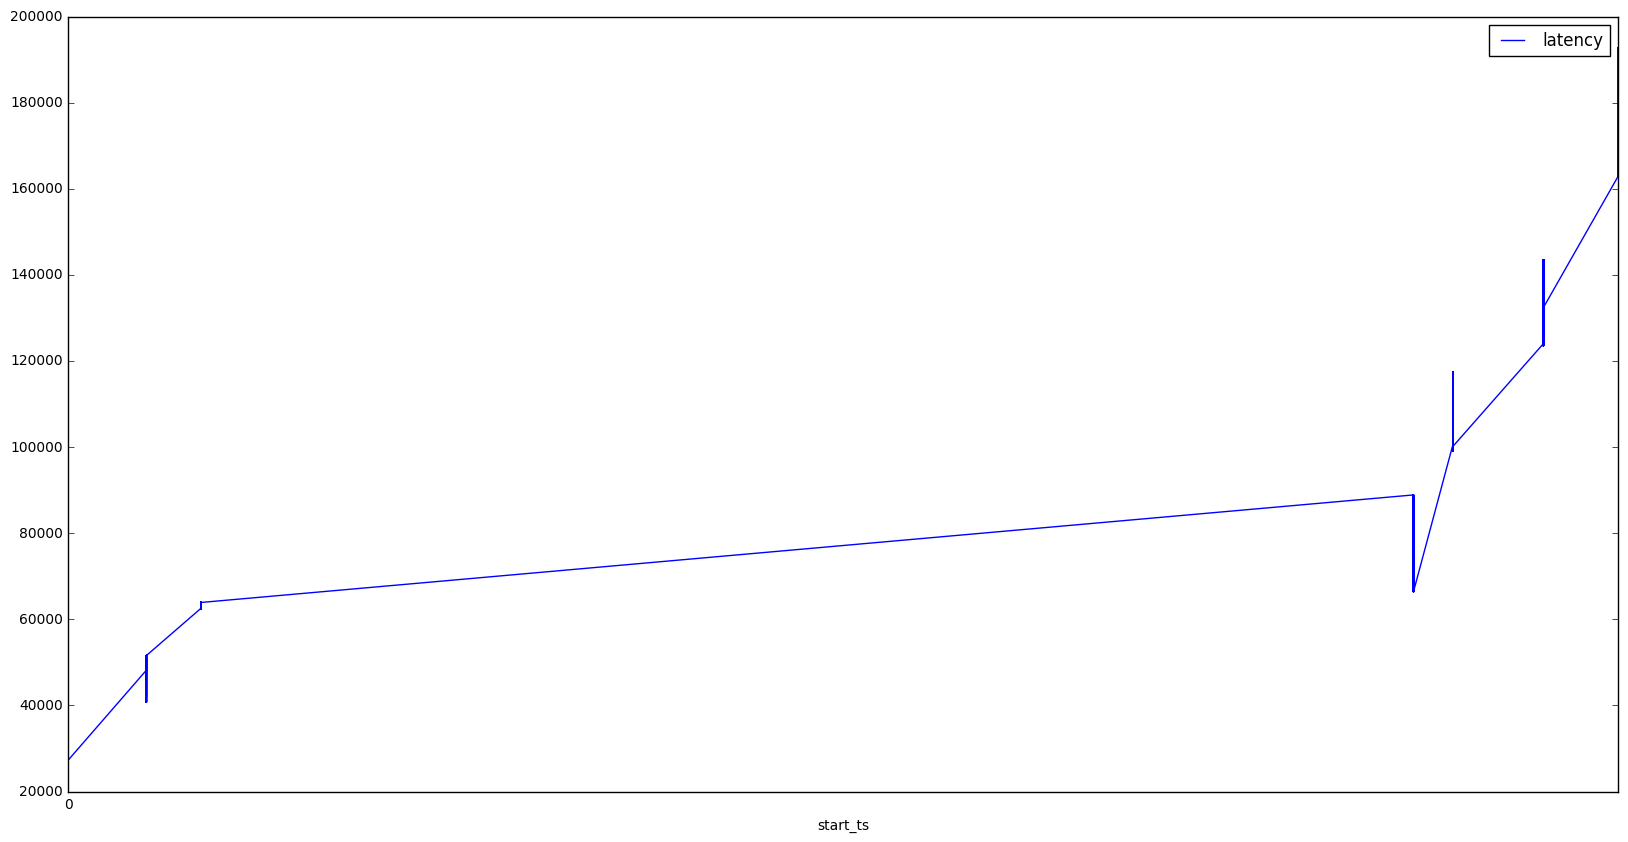

Latency quantile is:


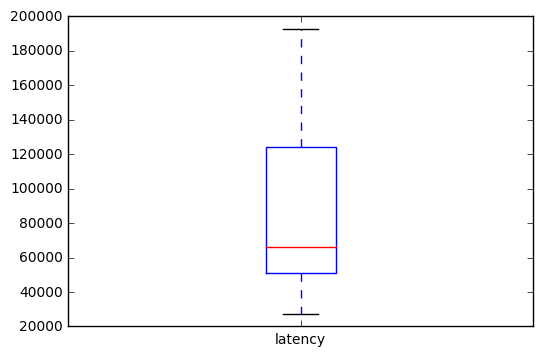

average latency is:
86689.2597403
 window size quantile is:


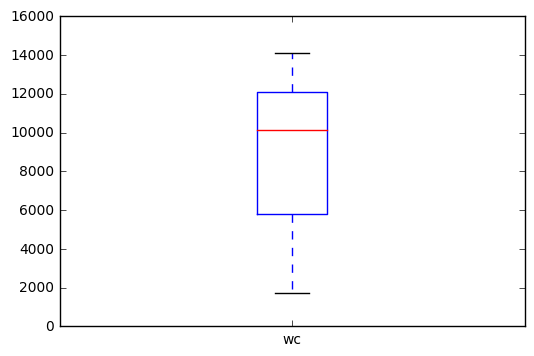

average window size is:
8977.25352908


In [62]:
print('ERROR TaskSchedulerImpl: Lost executor 7 on 130.149.21.20: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages')
print('Crashed')
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/spark/4x/results/spark_temp.csv',(20,10),25)

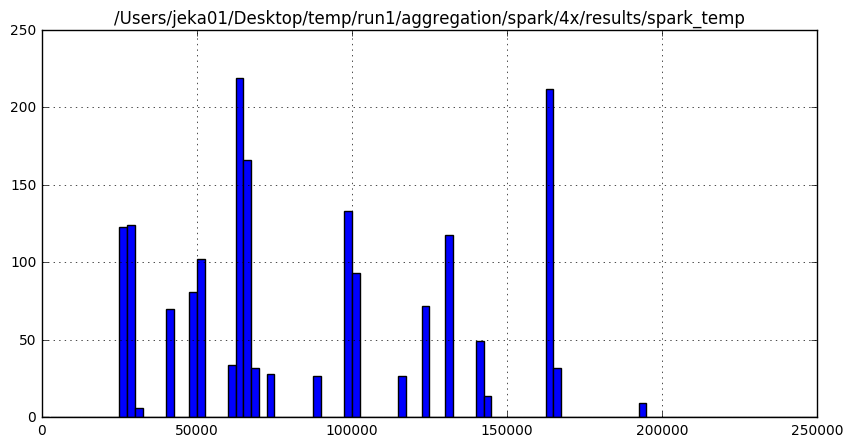

In [61]:
range = [0,250000]

pandasDraw([['/Users/jeka01/Desktop/temp/run1/aggregation/spark/4x/results/spark_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

ERROR TaskSchedulerImpl: Lost executor 7 on 130.149.21.20: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages
Crashed


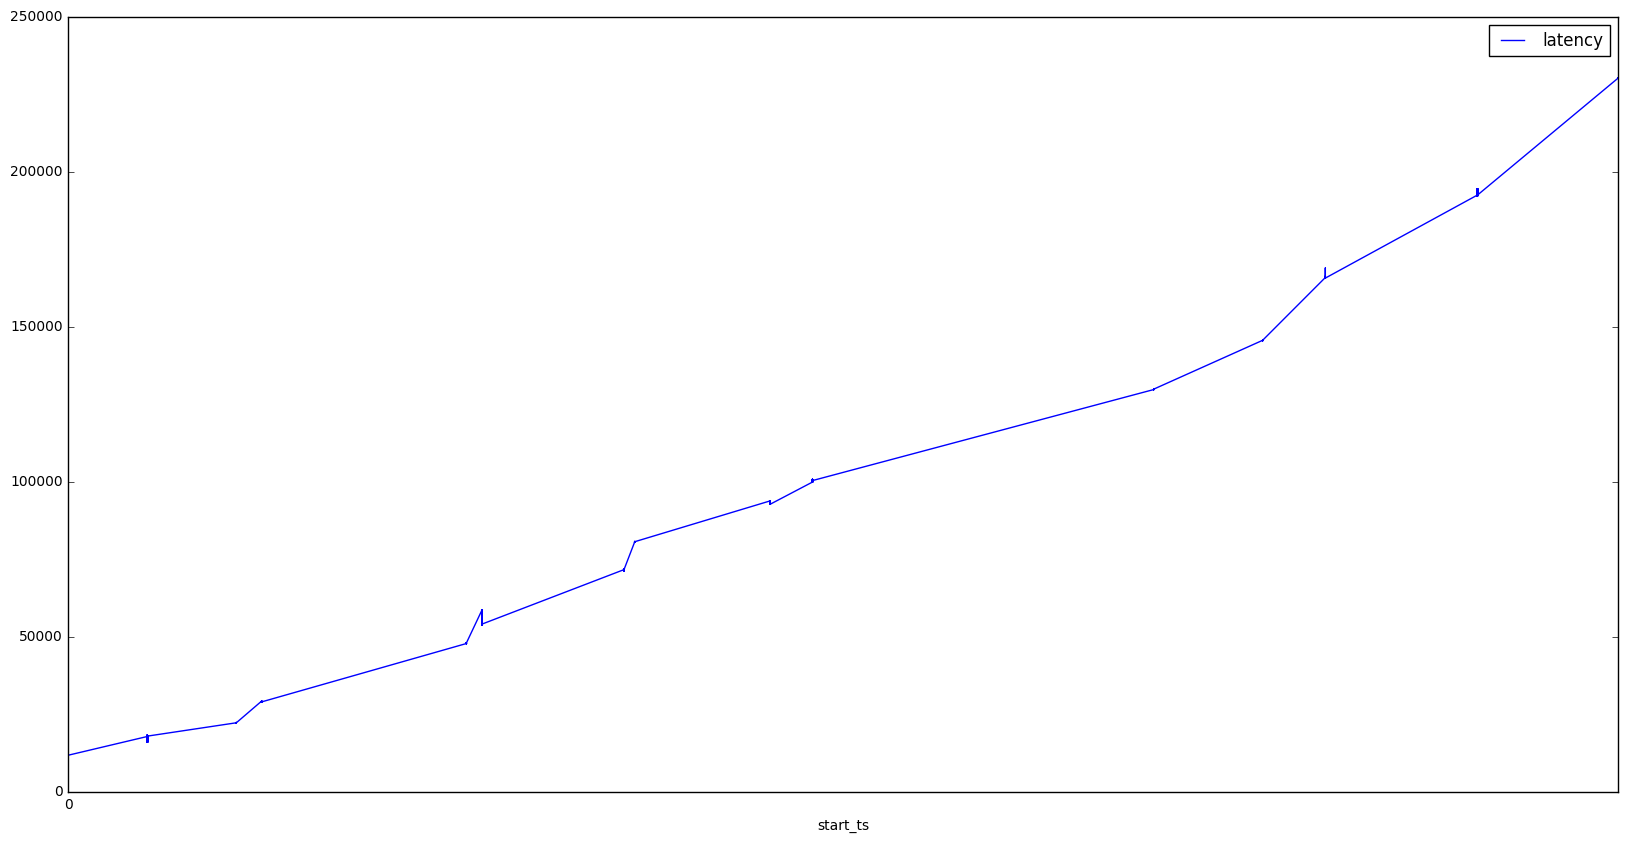

Latency quantile is:


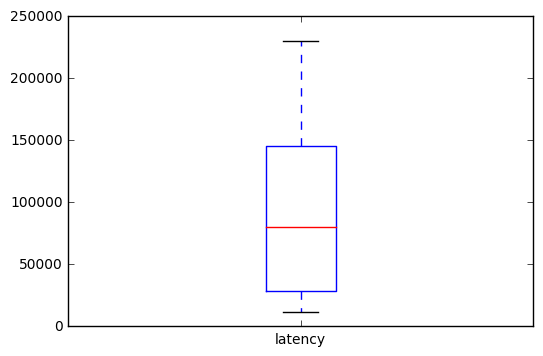

average latency is:
92819.9299078
 window size quantile is:


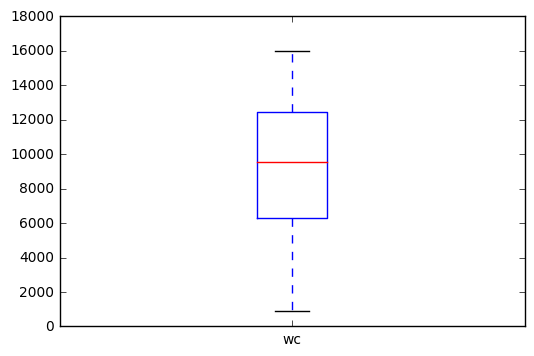

average window size is:
9119.63689065


In [63]:
print('ERROR TaskSchedulerImpl: Lost executor 7 on 130.149.21.20: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages')
print('Crashed')
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/spark/2x/results/spark_temp.csv',(20,10),25)

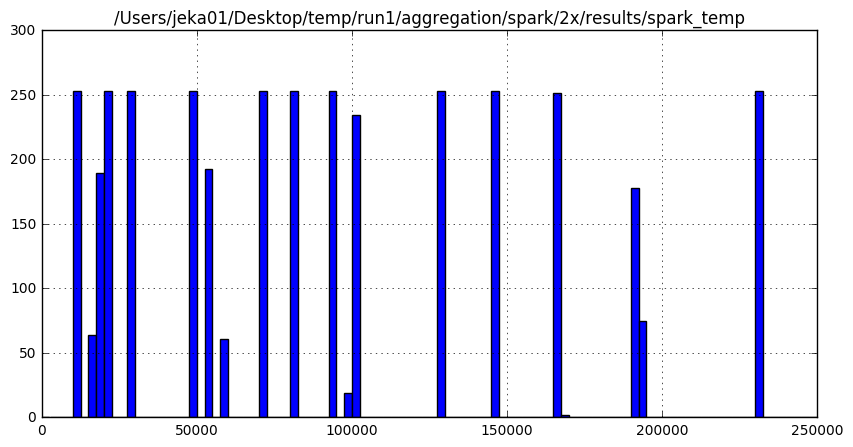

In [64]:
range = [0,250000]

pandasDraw([['/Users/jeka01/Desktop/temp/run1/aggregation/spark/2x/results/spark_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

Crashed


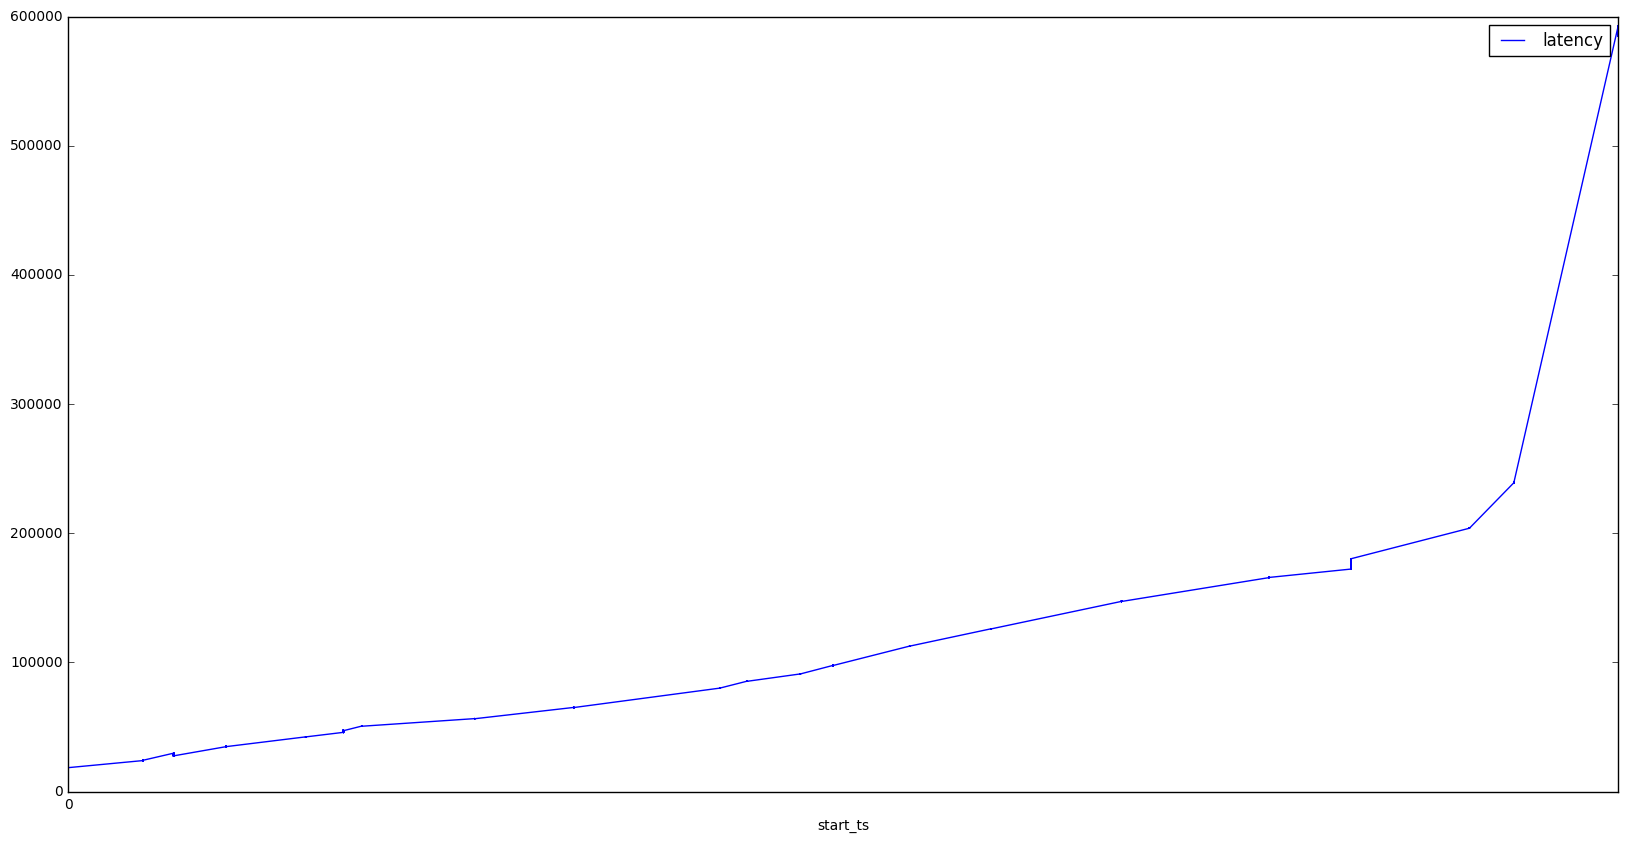

Latency quantile is:


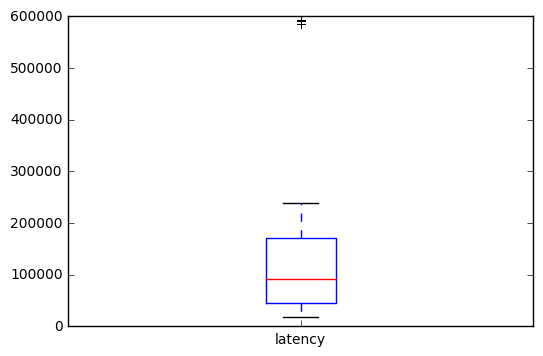

average latency is:
141101.85891
 window size quantile is:


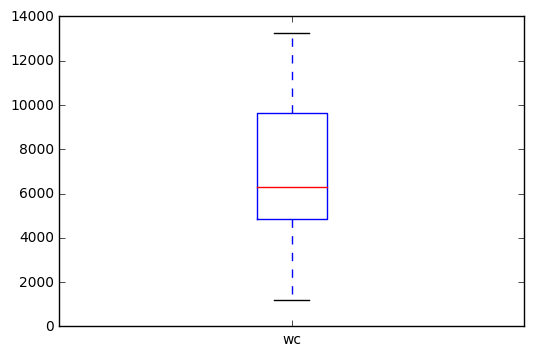

average window size is:
6957.43048634


In [65]:
print('Crashed')
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/spark/1x/results/spark_temp.csv',(20,10),25)

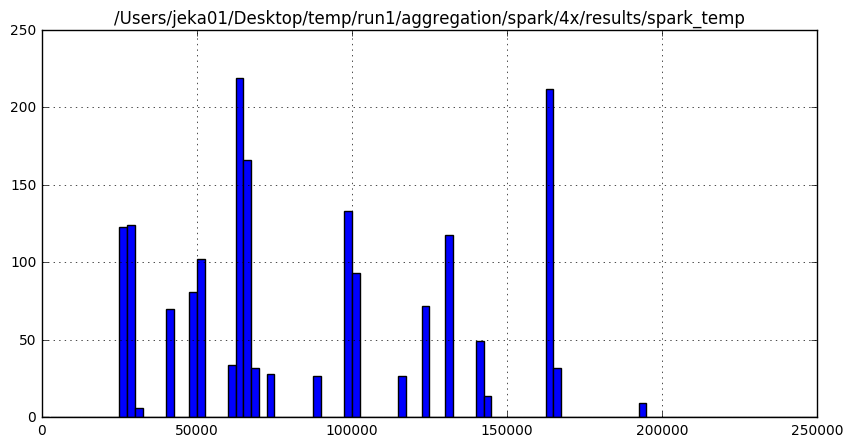

In [66]:
range = [0,250000]

pandasDraw([['/Users/jeka01/Desktop/temp/run1/aggregation/spark/4x/results/spark_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

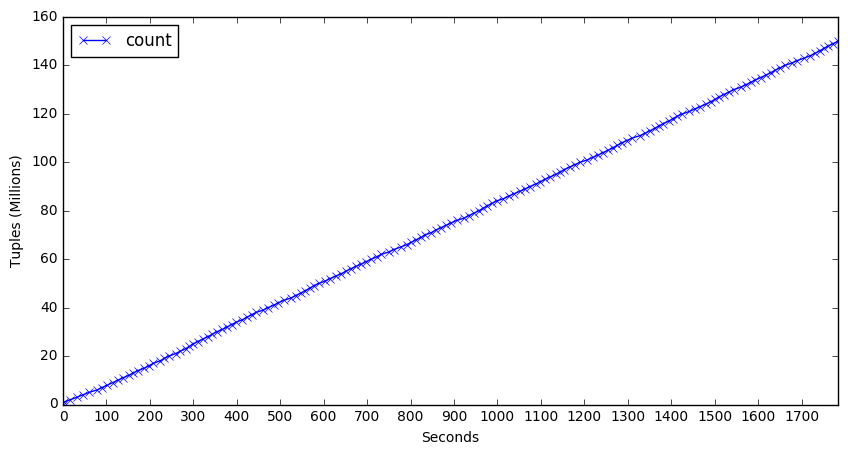

In [70]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/trident/1x/stats/consumer',(10,5),'Seconds','Tuples (Millions)',100)



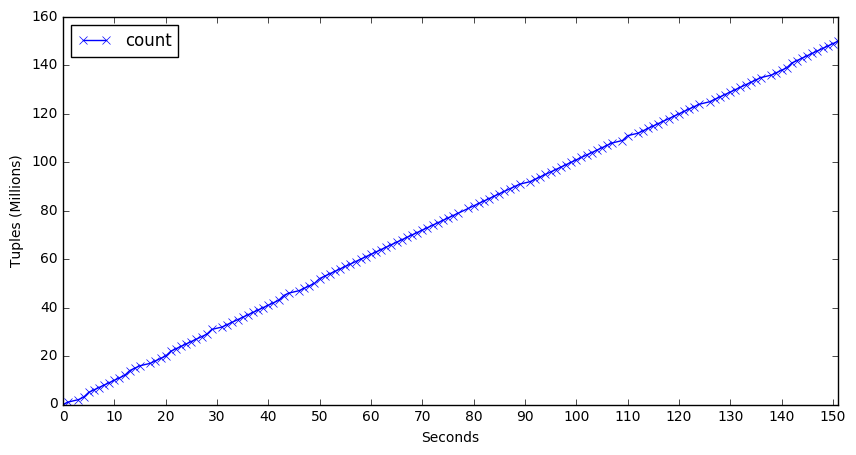

In [72]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/aggregation/trident/1x/stats/producer',(10,5),'Seconds','Tuples (Millions)',10)



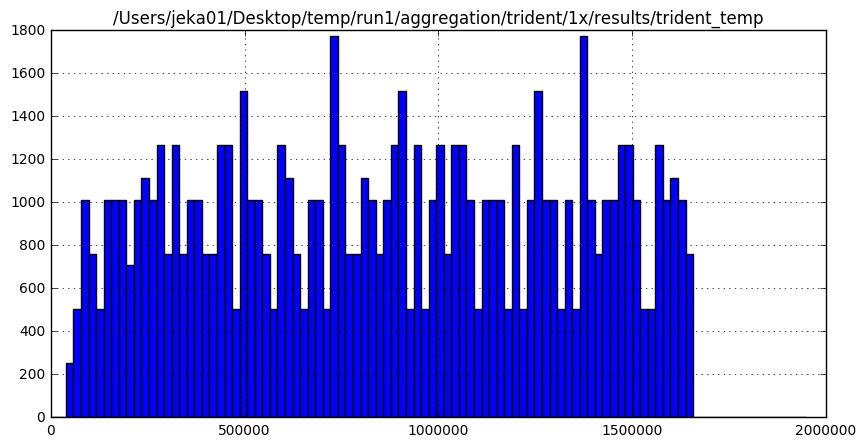

In [76]:
range = [0,1950000]

pandasDraw([['/Users/jeka01/Desktop/temp/run1/aggregation/trident/1x/results/trident_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

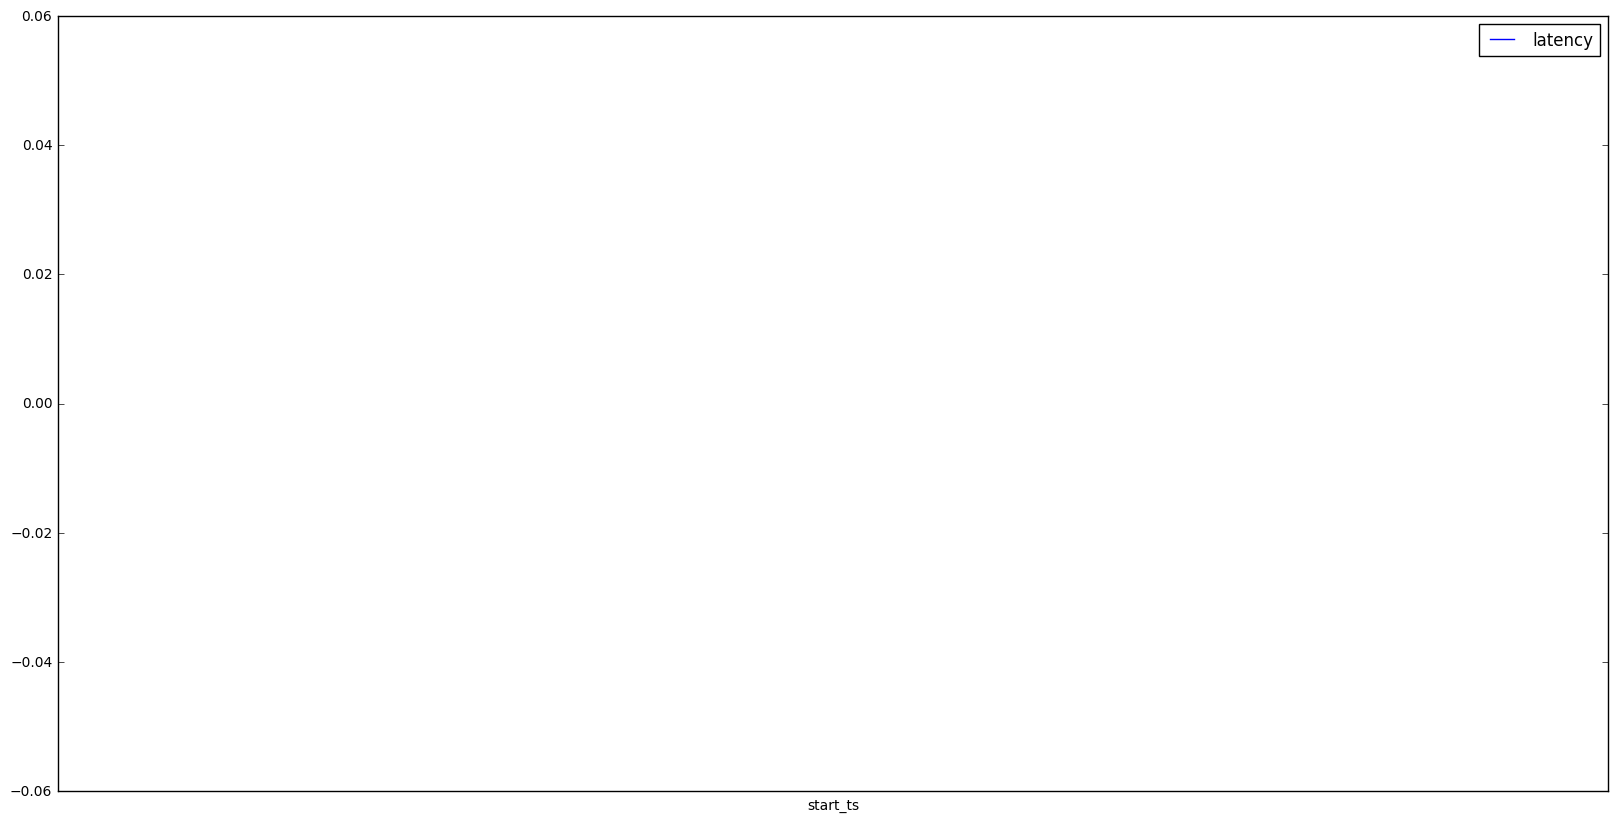

Latency quantile is:


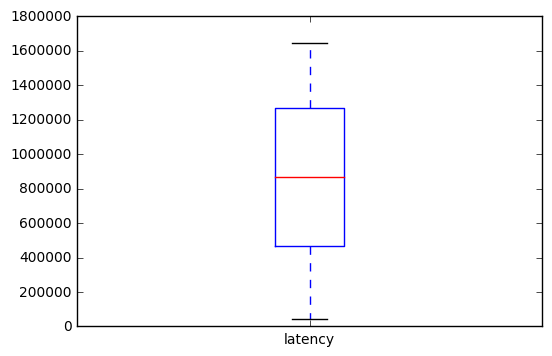

average latency is:
865105.872607
 window size quantile is:


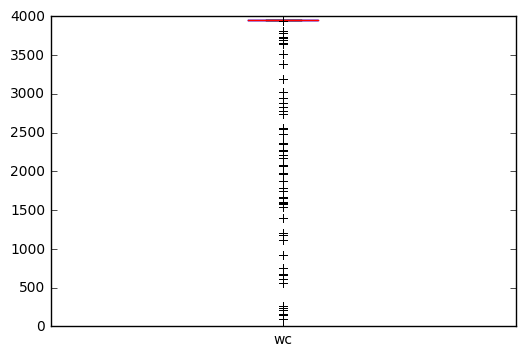

average window size is:
3501.87816907


In [78]:
latencyTimeSeries('/Users/jeka01/Desktop/temp/run1/aggregation/trident/1x/results/trident_temp.csv',(20,10),125)

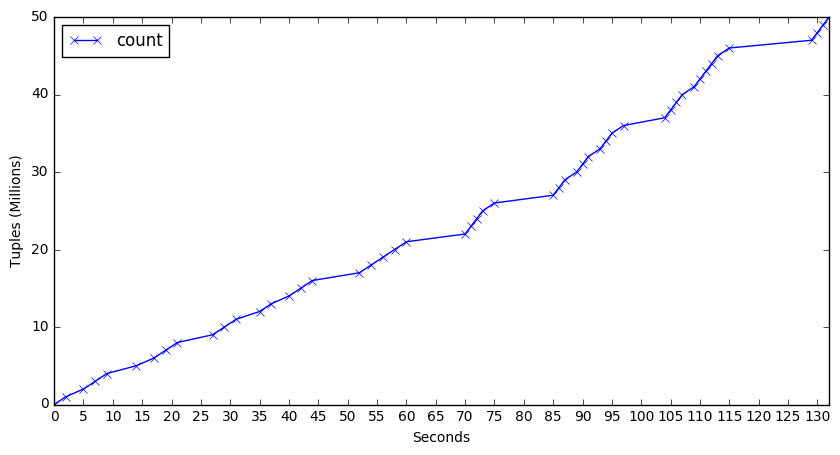

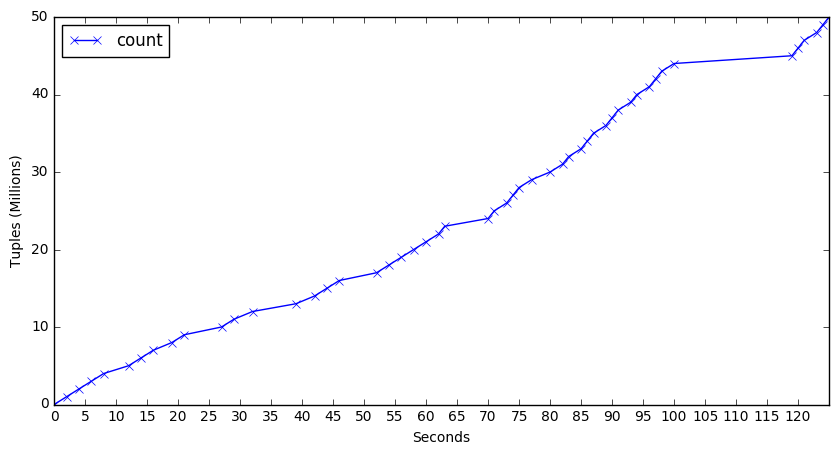

In [86]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/join/spark/1x/stats/consumer',(10,5),'Seconds','Tuples (Millions)',5)



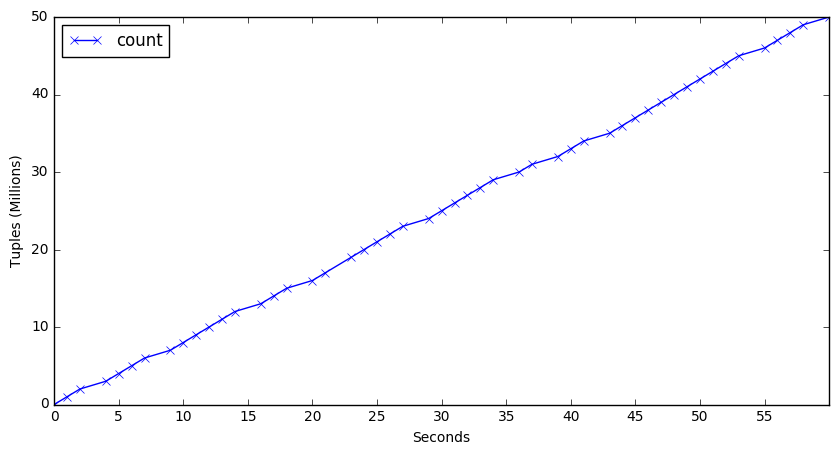

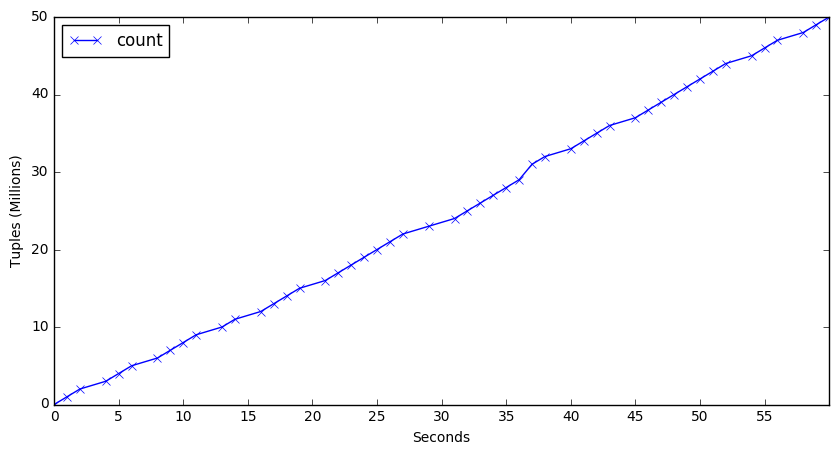

In [85]:
dataGeneratorStatsSeparateOneAxis2('/Users/jeka01/Desktop/temp/run1/join/spark/1x/stats/producer',(10,5),'Seconds','Tuples (Millions)',5)



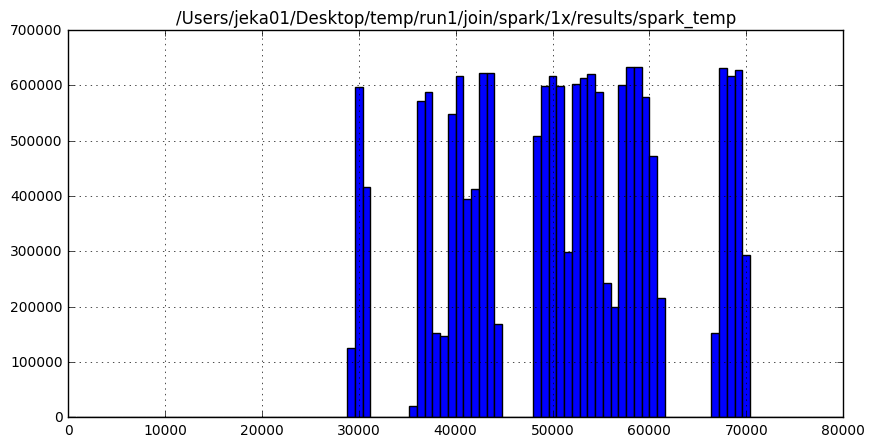

In [4]:
range = [0,80000]

pandasDraw([['/Users/jeka01/Desktop/temp/run1/join/spark/1x/results/spark_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()